The idea of that notebook is to have a reproducible benchmark working with the masters version of `pysap` and `modopt` in April 2019. The benchmark will be on speed, for both sparkling and uniform random acquisition schemes, with a brain phantom, for decimated wavelets.

The benchmark will future the algorithms of the abstract submission for SPARS 2019.

Special attention must be taken for Condat. We might need to qualify the benchmark with non reproducible experiments where we set the norm of the linear operator. We also need to take care of the relaxation factor.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

# Third party import
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
from tqdm import tqdm_notebook

# Package import
from modopt.math.metrics import ssim
import pysap
from pysap.data import get_sample_data
from pysap.numerics.fourier import NFFT
from pysap.numerics.reconstruct import sparse_rec_fista
from pysap.numerics.utils import generate_operators, convert_mask_to_locations


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

PyWavelets     : >=1.0.0   - required | ?         installed
matplotlib     : >=2.1.2   - required | 3.0.3     installed
pysparse       : >=0.0.1   - required | 0.0.2     installed
modopt         : >=1.1.5   - required | 1.2.0     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
nibabel        : >=2.1.0   - required | 2.3.3     installed
astropy        : ==2.0.8   - required | 2.0.8     installed
future         : >=0.16.0  - required | 0.17.1    installed
numpy          : >=1.11.0  - requi

#  Loading input data

In [2]:
image = get_sample_data("mri-slice-nifti")
original_image_data = np.copy(image.data)
image.data += np.random.randn(*image.shape) * 20.
image.data = image.data.astype(np.complex128)
mask = get_sample_data("mri-mask")

In [3]:
non_cartesian = True
opt_results = {}

# Generate the kspace 
From the 2D brain slice and the acquistion mask, we generate the acquisition measurments, the observed kspace. We then reconstruct the zero order solution.

In [4]:
# Generate the subsampled kspace
if non_cartesian:
    kspace_loc = convert_mask_to_locations(mask.data)
    fourier_op = NFFT(samples=kspace_loc, shape=image.shape)
    kspace_data = fourier_op.op(image.data)

    # Zero order solution
    image_rec0 = pysap.Image(data=fourier_op.adj_op(kspace_data), metadata=image.metadata)
else:
    kspace_mask = np.fft.ifftshift(mask.data)
    kspace_data = np.fft.fft2(image.data, norm="ortho") * kspace_mask

    # Get the locations of the kspace samples
    kspace_loc = convert_mask_to_locations(kspace_mask)

    # Zero order solution
    image_rec0 = pysap.Image(data=np.fft.ifft2(kspace_data, norm="ortho"), metadata=image.metadata)

# FISTA optimization
We now want to refine the zero order solution using a FISTA optimization.

In [5]:
# Generate operators
gradient_op, linear_op, prox_op, cost_op = generate_operators(
    data=kspace_data,
    wavelet_name="Db4",
    samples=kspace_loc,
    nb_scales=4,
    non_cartesian=non_cartesian,
    uniform_data_shape=image.shape,
    gradient_space="synthesis",
)

In [6]:
def objective_cost(x):
    return data_fidelity(x) + sparsity(x)

def sparsity(x):
    return mu * np.sum(np.abs(x))

def data_fidelity(x):
    return 0.5 * np.linalg.norm(gradient_op.op(x) - kspace_data)**2

In [7]:
def nrmse(x):
    return np.linalg.norm(x - original_image_data) / np.mean(original_image_data)

In [8]:
metrics_ = {
    "cost": {"metric": objective_cost, "mapping": {"z_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "nrmse": {"metric": nrmse, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
}

In [11]:
mu = 80

In [12]:
max_iter = 1000
convergence_pot = max_iter >= 500

In [13]:
# Start the FISTA reconstruction
cost_op = None
x_final, transform, costs, metrics = sparse_rec_fista(
    gradient_op,
    linear_op,
    prox_op,
    cost_op,
    mu=mu,
    lambda_init=1.0,
    max_nb_of_iter=max_iter,
    verbose=1,
    metrics=metrics_,
    metric_call_period=20,
)
image_rec = pysap.Image(data=np.abs(x_final))


  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  80
 - lipschitz constant:  4.399999999999921
 - data:  (512, 512)
 - wavelet:  <pysap.plugins.mri.reconstruct.linear.Wavelet2 object at 0x7f18df4ff438> - 4
 - max iterations:  1000
 - image variable shape:  (512, 512)
 - alpha variable shape:  (274786,)
----------------------------------------
Starting optimization...


100% (1000 of 1000) |####################| Elapsed Time: 0:03:23 Time:  0:03:23


 - converged:  False
Done.
Execution time:  1185.3843840000002  seconds
----------------------------------------


In [14]:
if convergence_pot:
    opt_results[mu] = {
        "nrmse": metrics['nrmse']['values'][-1],
        "gt_sim": metrics['gt_sim']['values'][-1],
        "cost": metrics['cost']['values'][-1],
    }
    print(opt_results)

{80: {'cost': 142568814.5258589, 'gt_sim': 0.8600992889588941, 'nrmse': 115.02801048471585}}


In [15]:
max_iter = 300

In [16]:
params = {
    r"FISTA-BT": ({}, "black"),
    r"FISTA-CD, $a = 20$": ({"a_cd": 20}, "blue"),    
    r"Rada-FISTA": (
        {"p_lazy": (1/30), "q_lazy": (1/10), "restart_strategy": "adaptive", "xi_restart": 0.96}, 
        "orange",
    ),
    r"greedy FISTA": (
        {"restart_strategy": "greedy", "xi_restart": 0.96, "s_greedy": 1.1}, 
        "violet",
    ),
}

res_param = {}
for param_name, (param, _) in tqdm_notebook(params.items()):
    _, _, _, metrics = sparse_rec_fista(
        gradient_op,
        linear_op,
        prox_op,
        None,
        mu=mu,
        lambda_init=1.0,
        max_nb_of_iter=max_iter,
        verbose=0,
        metrics=metrics_,
        metric_call_period=1,
        **param,
    )
    res_param[param_name] = {
        "cost": np.array(metrics['cost']['values']),
        "nrmse": np.array(metrics['nrmse']['values']),
    }

100% (300 of 300) |######################| Elapsed Time: 0:02:14 Time:  0:02:14
100% (300 of 300) |######################| Elapsed Time: 0:01:52 Time:  0:01:52
100% (300 of 300) |######################| Elapsed Time: 0:01:51 Time:  0:01:51
100% (300 of 300) |######################| Elapsed Time: 0:01:58 Time:  0:01:58


<IPython.core.display.Javascript object>


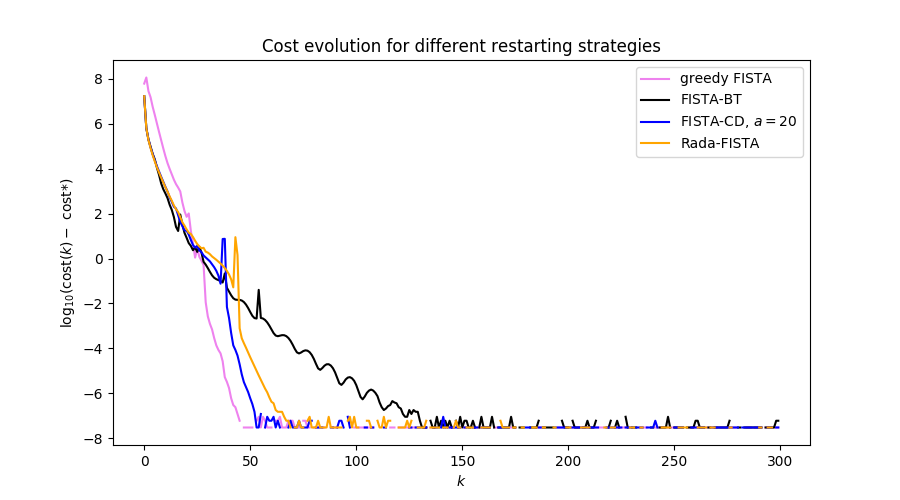

/home/ramzi/workspace/pysap/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Text(0, 0.5, '$\\log_{10}($cost$(k) -$ cost$*)$')

In [17]:
metric_name = "cost"
plt.figure(figsize=(9, 5))
for param_name, param_res in res_param.items():
    plt.plot(
        np.log10(np.abs(np.array(param_res[metric_name] - opt_results[mu][metric_name]))), 
        label=param_name, 
        color=params[param_name][1],
    )
plt.legend()
plt.title(r"Cost evolution for different restarting strategies")
plt.xlabel(r"$k$")
plt.ylabel(r"$\log_{10}($cost$(k) -$ cost$*)$")